<a href="https://colab.research.google.com/github/wagner-niklas/KIT_ML_EmotionRecognition/blob/main/KIT_EmotionRecognition_AffectNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import drive
import pandas as pd
import numpy as np
import time

# Check for GPU (else go to settings in Google Colab)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("RUNNING ON ", device) # should be cuda

RUNNING ON  cpu


In [ ]:
# Model parameters

NUM_EPOCHS= 10
EARLY_STOPPING_LIMIT = 10
NUM_CLASSES = 2     # Output of 2 labels
BATCHSIZE = 32
LR=1e-5             # Learning rate
LRD_STEP_SIZE = 1   # Period of learning rate decay
LRD_GAMMA = 0.85    # Multiplicative factor of learning rate decay. Default: 0.1
DROPOUT_RATE= 0.4   # probability of an element to be zeroed. Default: 0.5

# Paths

ROOT = '/content/drive/'
MYDRIVE = ROOT + "MyDrive/AffectNet/"
IMAGE_FOLDER = MYDRIVE + "val_set/images/"
CSV_PATH = MYDRIVE + "val_set/val_set_annotation_without_lnd.csv"

drive.mount(ROOT) # Mount to google drive

Mounted at /content/drive/


Random Train/Val data:


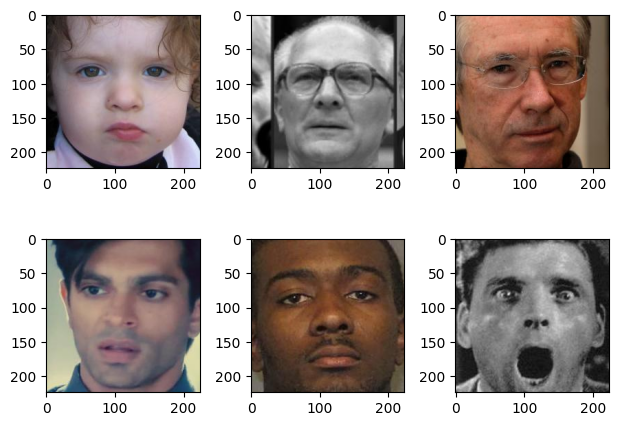

In [ ]:
# Inspect random data

print(f"Random Train/Val data:")

fig = plt.figure()
train_val_root = IMAGE_FOLDER
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(Image.open(train_val_root + sorted(os.listdir(train_val_root))[i]))

plt.show()

In [ ]:
# Read the csv with the image data

df = pd.read_csv(CSV_PATH)

df.rename(columns=df.iloc[0])
labels = df[['val', 'aro']].values # define the labels for the model

df.head()

,number,exp,val,aro
0,0,0,-0.176846,-0.077640
1,1,0,-0.367789,0.183895
2,2,4,-0.062911,0.532327
3,3,0,0.004839,-0.004839
4,4,2,-0.642857,-0.507936


In [ ]:
#Build custom dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.dataframe['number'][idx]}.jpg")
        image = Image.open(img_name)

        labels = torch.tensor(self.dataframe.iloc[idx, 2:].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],  # mean of ImageNet
                                 std=[0.229, 0.224, 0.225])   # std of ImageNet

# Define any image transformations
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomRotation(10),       # Tilt here
                                transforms.CenterCrop(210), # crop every image to size 224x224 -> changed to 200
                                # transforms.RandomGrayscale(0.01),
                                # normalize,
                                transforms.ToTensor()], # saves image as tensor (automatically divides by 255)
                               )

# Create the dataset
custom_dataset = CustomDataset(dataframe=df, root_dir=IMAGE_FOLDER, transform=transform)

# Split the dataset into train, validation, and test sets
total_size = len(custom_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

NameError: ignored

In [ ]:
# Test and visualize the train loader

def vis_batch(loader, header=""):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1, 2, 0))
        plt.title(label)

    for batch_inputs, labels in loader:
        # Move inputs and labels to the device (GPU)
        batch_inputs, labels = batch_inputs.to(device), labels.to(device)

        grid = torchvision.utils.make_grid(batch_inputs.cpu())  # Move to CPU for visualization
        show(grid, label=f'{header}\nLabels: {labels.cpu().numpy()}')
        plt.show()
        break

vis_batch(train_loader, header="val, aro")

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
# Define the model with dropout and weight decay
class CustomModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.base_model = models.swin_v2_s(weights='DEFAULT')#.to(device) ??
   #     n_inputs = self.base_model.head.in_features
   #     self.fc1 = nn.Linear(n_inputs, 256)
   #     self.fc2 = nn.Linear(256, 128)
   #     self.fc3 = nn.Linear(128, num_classes)

 #   def forward(self,x):
  #      x = nn.functional.relu(self.fc1(x))
   #     x = nn.functional.relu(self.fc2(x))
    #    return nn.functional.relu(self.fc3(x))


        # To only train the classifier of the model:
        # for param in self.base_model.parameters():  # We don't want to change the learned ImageNet weights. Disable gradient calculation for CNN
        #    param.requires_grad = False

        n_inputs = self.base_model.head.in_features
        self.base_model.head = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

# Define the model
model = CustomModel(NUM_CLASSES, DROPOUT_RATE) # Number of output classes

# Specify the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# optimizer = torch.optim.AdamW(model.base_model.head.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LRD_STEP_SIZE, gamma=LRD_GAMMA)

# Define loss function and optimizer with weight decay
criterion = nn.MSELoss()

# Assuming you have a DataLoader named 'train_loader'
# Example training loop
print("Start training:")

start = time.time()
early_stopping_counter = 0
previous_val_loss = np.inf
best_val_loss = previous_val_loss

# For plotting
train_loss_history = []
valid_loss_history = []

# model.load_state_dict(torch.load('checkpoint.pt'))   # loading best weights

for epoch in range(NUM_EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    scheduler.step()

    train_loss_history.append(loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    average_val_loss = val_loss / len(val_loader)
    valid_loss_history.append(best_val_loss)

    # Early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(),"checkpoint.pt")   # saving best weights so far
    else:
        early_stopping_counter += 1
        if early_stopping_counter == EARLY_STOPPING_LIMIT:
            print("*" * 70)
            model.load_state_dict(torch.load('checkpoint.pt'))      # loading best weights
            print(f"Early-Stopping activated: Using weights from epoch {epoch+1-EARLY_STOPPING_LIMIT}")
            print(f"Result: Validation Loss =  {best_val_loss:.4f}")
            # plt.axvline(epoch+1-early_stopping_limit, label="Early Stopping", color='r')
            break

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {loss.item()}, Validation Loss: {average_val_loss}, Early Stopping Counter: {early_stopping_counter}, Timestamp: {round(time.time() - start)} seconds')

# Print loss curves
fig = plt.figure() # For a figur of the training
plt.plot(range(1,1+len(train_loss_history)),train_loss_history, label="Training Loss")
if len(train_loss_history) == len(valid_loss_history):
    plt.plot(range(1,1+len(valid_loss_history)),valid_loss_history, label="Validation Loss")
else:
    plt.plot(range(0,len(valid_loss_history)),valid_loss_history, label="Validation Loss")

plt.legend()
plt.show()


print(f"This took {round(time.time() - start)} seconds")


Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 129MB/s] 


Start training:


Test Loss: 0.1816692570081124


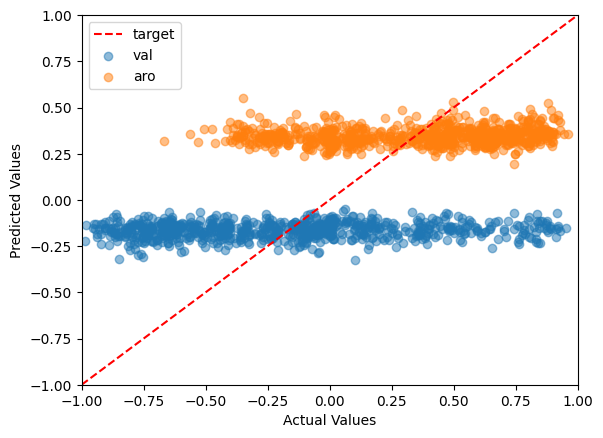

In [ ]:
# Test and visualize the performance on the test set
def test_and_visualize(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    predictions = []
    targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

            predictions.append(outputs.cpu().numpy())
            targets.append(labels.cpu().numpy())

    average_test_loss = test_loss / len(test_loader)

    # Convert lists to numpy arrays
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    # Display performance metrics or visualizations as needed
    print(f'Test Loss: {average_test_loss}')

    return predictions, targets

# Test the model and visualize the performance
predictions, targets = test_and_visualize(model, test_loader, criterion)

# Example: Plotting predicted vs. actual values
x_target= [-1, 1]
y_target= [-1,1]
plt.plot(x_target,y_target, linestyle='--', label='target', color='red')

# plt.scatter(targets[:, 0], predictions[:, 0], label='exp', alpha=0.5)
plt.scatter(targets[:, 0], predictions[:, 0], label='val', alpha=0.5)
plt.scatter(targets[:, 1], predictions[:, 1], label='aro', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(-1.,1.)
plt.ylim(-1.,1.)
plt.legend()
plt.show()